# Практическое домашнее задание 1. Поиск похожих изображений с помощью SVD.

Версия от 29.01.2022.

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения — поиск "хорошего" базиса (eigenfaces) в наборе изображений и использования его для поиска похожих изображений.

**Замечание:** пользоваться циклами по изображениям во всех заданиях **запрещено**.

Для этого сначала загрузим набор изображений, на котором будем обучаться. Это набор фотографий лиц, взятый с [сайта](http://vis-www.cs.umass.edu/lfw/) проекта "Labeled faces in the wild". Скачайте лица людей с именами, начинающимися на "А" и положите в папку `data/` в рабочей директории ноутбука.

Импортируем необходимые библиотеки и загрузим картинки в виде numpy-массивов. 

In [1]:
import matplotlib.pyplot as plt
import PIL
import tarfile
import os
import numpy as np

def load_images(targz, size):
    images = {}
    tar = tarfile.open(targz, "r:gz")
    for tarinfo in tar:
        if tarinfo.isreg():
            file = tar.extractfile(tarinfo)
            image = PIL.Image.open(file)
            image = image.convert("L")
            image = image.resize(size, PIL.Image.ANTIALIAS)
            image = np.asarray(image, dtype=np.double)
            image /= np.linalg.norm(image)
            parts = os.path.normpath(tarinfo.name).split(os.path.sep)
            images.setdefault(parts[-2], []).append(image)
    return images

In [2]:
size = 256
images = load_images("data/lfw-a.tgz", (size, size))

In [3]:
list(images.items())[0]

('Aaron_Eckhart',
 [array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          4.27197920e-05, 4.27197920e-05, 4.27197920e-05],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 4.27197920e-05, ...,
          1.28159376e-04, 1.28159376e-04, 1.28159376e-04],
         ...,
         [5.08365525e-03, 5.33997400e-03, 5.68173234e-03, ...,
          5.59629276e-03, 6.10893026e-03, 6.40796880e-03],
         [5.04093546e-03, 5.12637504e-03, 5.38269380e-03, ...,
          5.89533130e-03, 6.40796880e-03, 6.70700735e-03],
         [4.87005629e-03, 4.95549588e-03, 5.21181463e-03, ...,
          6.15165005e-03, 6.57884797e-03, 6.87788652e-03]])])

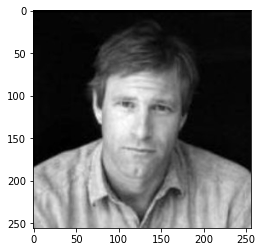

In [4]:
_ = plt.imshow(images["Aaron_Eckhart"][0], cmap="gray")

Сразу отложим одно изображение для последующего поиска.



In [5]:
test_image = images["Alejandro_Toledo"][10]
del images["Alejandro_Toledo"][10]

### a. Применение базового алгоритма SVD (35 баллов)

1. **(4 балла)** С помощью функции ```np.reshape(...)``` получите из словаря `images` массив ```M``` размера ```(size * size, nframes)```, каждым столбцом которого является изображение размера ```(size, size)```, представленное в виде вектора длины ```size**2``` (используйте такое значение параметра `order`, чтобы обходить картинки по столбцам).

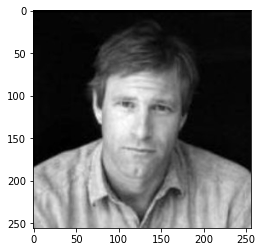

In [111]:
a = np.concatenate(list(images.values()))
M = np.reshape(a, (1053, size**2), order = 'F').T
M.shape
plt.imshow(M[:,0].reshape((size, size), order = "F"), cmap="gray")

2. **(10 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd``` и постройте график сингулярных чисел, отсортированных по убыванию. Шкала с сингулярными числами должна быть логарифмической. Например, для этого можно использовать функцию ```plt.semilogy```.
 
    **Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел.

In [112]:
U, Sigma, V_t = np.linalg.svd(M, full_matrices=False)
Sigma

array([2.75615482e+01, 6.76455206e+00, 5.07693126e+00, ...,
       5.44774274e-02, 5.37564903e-02, 1.25568514e-02])

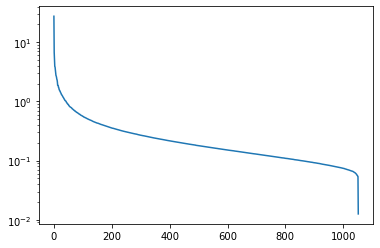

In [113]:
plt.semilogy(Sigma);

 3. **(5 баллов)** Заполните пропуск в следующей функции, которая должна визуализировать вектор-столбцы нашей матрицы в виде таблицы. Затем с её помощью визуализируйте несколько первых сингулярных векторов. Опишите неформально, за что отвечают три старших сингулярных вектора.

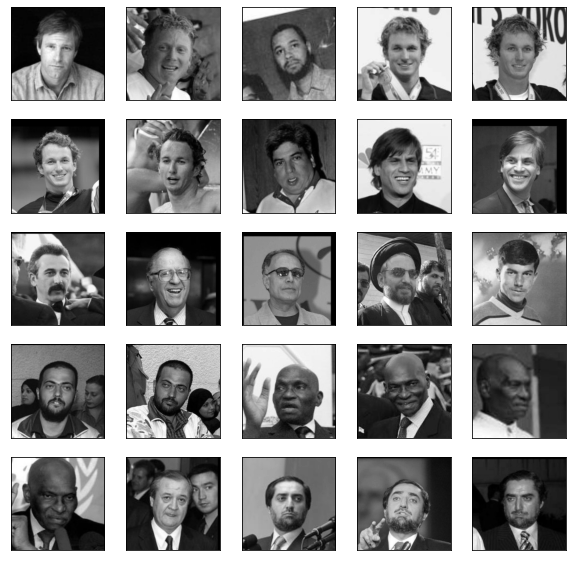

In [114]:
def plot_as_images(mat, rows, cols):    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2,rows*2))
    for i in range(rows):
        for j in range(cols):
            axes[i,j].imshow(mat[:,i*cols + j].reshape((size, size), order = 'F'), cmap="gray")
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
            
plot_as_images(M, 5, 5)

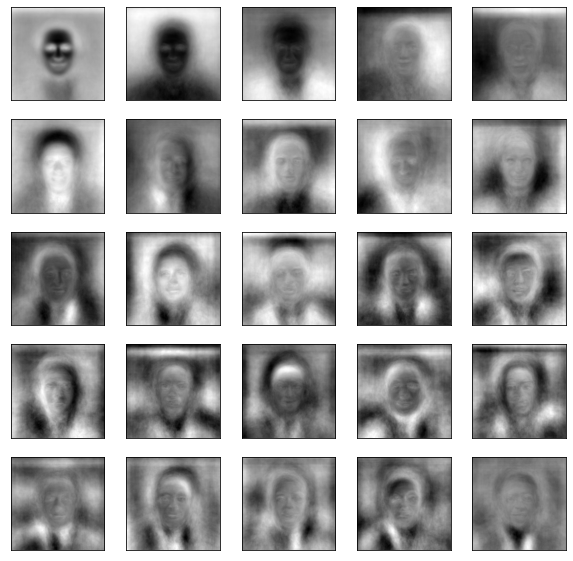

In [115]:
plot_as_images(U, 5, 5)

Насколько я понял они отвечают за контрастность и освещенность, первый вектор так уж точно за освещенность, ибо кажется в любой фотографии освещенность несет наибольший импакт

4. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая вычисляет оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга. Функция должна возвращать матрицы $U$ и $C$ такие, что столбцы матрицы $U$ составляют ортонормированный базис столбцов $M_{r}$, а $UC = M_{r}$. Также функция `trunc_svd` возвращает **относительную** точность приближения во Фробениусовой норме, т.е.
$$
    \frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для вычисления относительной точности используйте только полученные из сингулярного разложения сингулярные числа.

In [116]:
def trunc_svd(M, r):
    U, S, V_t = np.linalg.svd(M, full_matrices = False)
    U_r = U[:,:r]
    V_t_r = V_t[:r,:] ## Полные штаны говнокода
    C = np.diag(S[:r]) @ V_t_r
    coef = np.sum(S**2)
    S[S > S[r]] = 0
    coef1 = np.sum(S**2)
    rel_eps = coef1**0.5/coef**0.5
    return U_r, C, rel_eps 
trunc_svd(M, 5)

(array([[-0.00213322,  0.00410322, -0.00027847, -0.0072338 ,  0.00581192],
        [-0.00217285,  0.00411496, -0.00025856, -0.00734518,  0.0058514 ],
        [-0.00223139,  0.00425335, -0.00025173, -0.00741837,  0.00585449],
        ...,
        [-0.00292571, -0.00232334,  0.00705597,  0.00116304,  0.0044115 ],
        [-0.0029236 , -0.00233974,  0.00699472,  0.00113678,  0.00434874],
        [-0.00291816, -0.00233038,  0.00699632,  0.00114794,  0.00426131]]),
 array([[-0.76611841, -0.88613912, -0.91490376, ..., -0.89280903,
         -0.86003099, -0.90218504],
        [-0.4871657 , -0.02804165,  0.1054443 , ...,  0.04715945,
          0.13664409,  0.09819209],
        [ 0.18560464,  0.13733005,  0.09766574, ..., -0.02552778,
         -0.01924364, -0.06140687],
        [-0.10778623, -0.12023452, -0.09057634, ..., -0.11801351,
         -0.18986019, -0.25218291],
        [ 0.01373431, -0.03660136,  0.2149348 , ...,  0.0556105 ,
          0.02244817,  0.01314441]]),
 0.42702594139365435)

5. **(6 баллов)** Проверим работу написанной функции. Для этого воспользуемся функцией, которая рисует исходное изображение, приближение некоторого ранга, а также первые `count` сингулярных векторов в разложении вместе с их коэффициентами. Заполните пропуски в ней с помощью метода `reshape`.

In [117]:
def plot_as_combination(M, U, C, count, indices):
    fig, all_axes = plt.subplots(len(indices), count + 2, figsize=(count * 2, len(indices)*2))

    for i, index in enumerate(indices):
        axes = all_axes[i, :]

        axes[0].imshow(M[:, index].reshape((size, size), order = 'F'), cmap="gray") # Original image
        axes[0].set_xlabel("Orig")

        appr = U @ C[:, index]
        axes[1].imshow(appr[:].reshape((size, size), order = 'F'), cmap="gray") # Approximation image
        axes[1].set_xlabel("Appr")

        for i in range(count):
            axes[2 + i].imshow(U[:,i].reshape((size, size), order = 'F'), cmap="gray") # i-th singular vector image
            axes[2 + i].set_xlabel("{:.7}".format(C[i, index]))
        
        for ax in axes:
            ax.set_xticks([])
            ax.get_yaxis().set_visible(False)

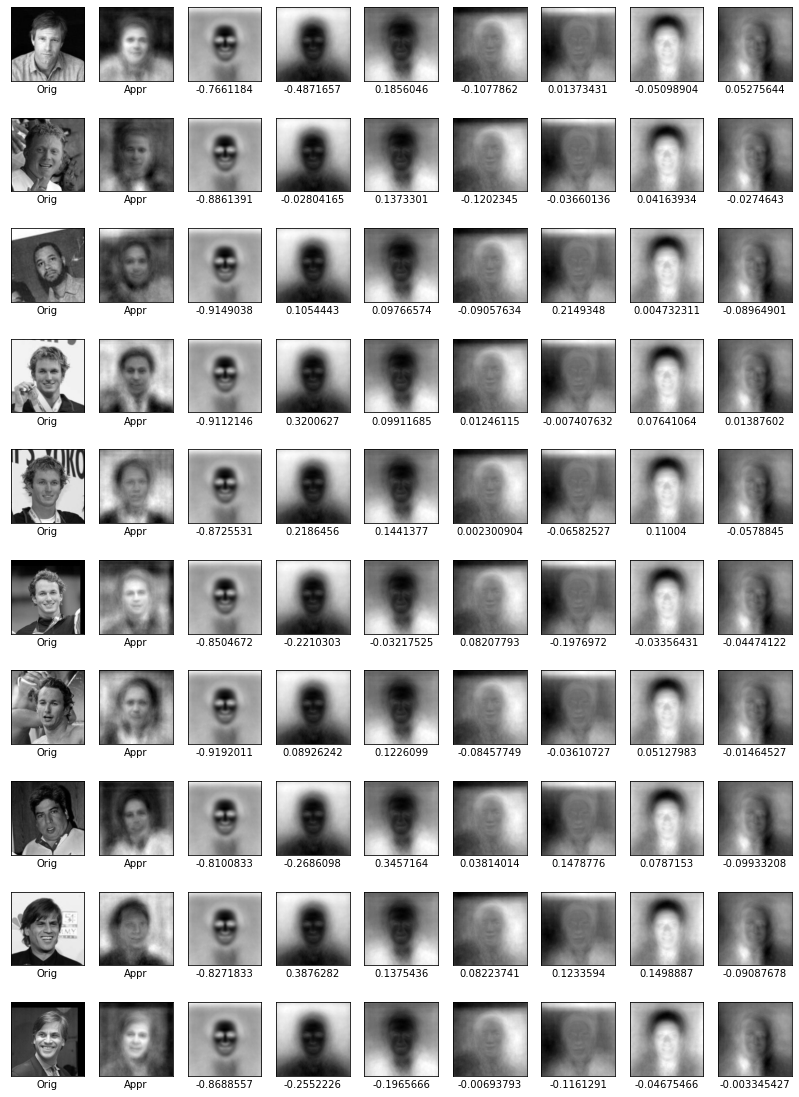

In [135]:
U, C, eps = trunc_svd(M, 50)
plot_as_combination(M, U, C, 7, range(10))

### b. Применение рандомизированного алгоритма SVD (35 баллов)

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого (кубического) роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений.

1. **(20 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + p``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы **не вычисляете** в явном виде матрицу $QQ^*$.

In [133]:
def rand_svd(M, r, p=10):
    Omega = np.random.rand(M.shape[1], r+p)
    Y = M @ Omega
    Q, R = np.linalg.qr(Y)
    B_part = Q.T @ M
    W, S, V_t = np.linalg.svd(B_part, full_matrices = False)
    U = Q @ W
    ## Тогда наше SVD = Q @ W @ S @ V_t = U @ S @ V_t
    Sigma = np.diag(S[:r]) #Обрезаем p векторов
    V_t = V_t[:r, :]
    U_t = U[:, :r]
    SVD = U_t @ Sigma @ V_t
    rel_eps = np.linalg.norm(M - SVD, ord = 'fro') / np.linalg.norm(M, ord = 'fro')
    return SVD, rel_eps

In [134]:
rand_svd(M, 10, 10)

(array([[0.00145871, 0.00273774, 0.00398325, ..., 0.00282286, 0.00361094,
         0.00367269],
        [0.00133256, 0.00263485, 0.00416226, ..., 0.00299219, 0.00374022,
         0.00380498],
        [0.00133875, 0.00247592, 0.00435486, ..., 0.00314165, 0.00380673,
         0.00399679],
        ...,
        [0.00374537, 0.00280527, 0.00559008, ..., 0.00409046, 0.00436967,
         0.00296227],
        [0.00389179, 0.00283222, 0.00555025, ..., 0.00409083, 0.00436036,
         0.00289274],
        [0.00383798, 0.00275134, 0.0055878 , ..., 0.00407102, 0.00430808,
         0.00282504]]),
 0.4310219808597973)

2. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M_{SVD} - M||_F} - 1
$$
в зависимости от $p$ для $r=50$. По $p$ выберите сетку $[0, 100]$ с шагом 5.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу.

In [ ]:
def norm_function(M, r = 50):
    ans = np.array([])
    n_times = 10
    _, _, trunc_eps = trunc_svd(M, r)
    for j in np.arange(0, 105, 5):
        accom = 0
        for i in range(0, n_times):
            _, rand_eps = rand_svd(M, r, j)
            accom += rand_eps
        accom /= n_times
        print(j)
        ans = np.append(ans, accom/trunc_eps - 1)
    return ans

    

3. **(5 баллов)** С помощью ```%timeit``` сравните время расчета для ```trunc_svd``` и ```rand_svd``` для ранга $r = 50$. Во сколько раз рандомизированный алгоритм быстрее ```np.linalg.svd``` для матрицы ```M```?

In [18]:
%timeit trunc_svd(M, 50)

KeyboardInterrupt: 

In [ ]:
%timeit rand_svd(M, 50)

### c. Поиск нового изображения (30 баллов)

Представьте, что нам выдали новое изображение `new`, которого в нашей базе нет. Чтобы найти в базе похожие, можно посчитать норму разности с каждым имеющимся изображением. Для проверки напишем вспомогательную функцию, которая будет показывать подписанные картинки.

In [125]:
def show_images(M, indices, names):
    fig, axes = plt.subplots(1, len(indices), figsize=(len(indices)*3, 3))
    for ax, index in zip(axes, indices):
        ax.imshow(M[:,index].reshape((size, size), order="F"), cmap="gray")
        ax.get_xaxis().set_ticks([])
        ax.set_xlabel(names[index])
        ax.get_yaxis().set_visible(False)

   1. **(10 баллов)** Напишите функцию, находящее ближайшее во фробениусовой норме изображение.

In [126]:
def get_closest_naive(M, new_v, count):
    buff = M - new_v.reshape(size**2, 1)
    return np.argsort(np.linalg.norm(buff, axis = 0))[:count]

Проверим её на тестовом изображении. Как минимум один Алехандро Толедо должен найтись.

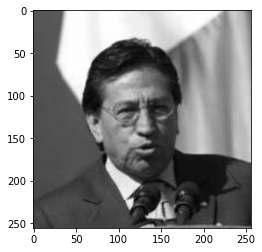

In [127]:
new = test_image
_ = plt.imshow(new, cmap="gray")

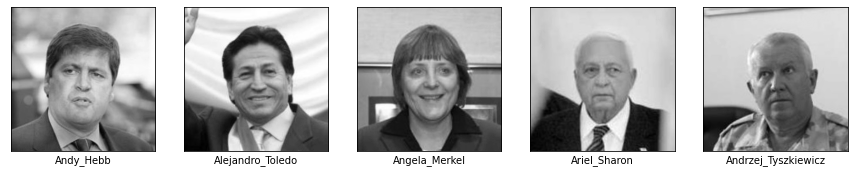

In [136]:
new_v = new.ravel(order="F")
names = sum(map(lambda item: [item[0]] * len(item[1]), images.items()), [])
show_images(M, get_closest_naive(M, new_v, 5), names)

Помимо того, что такой подход может оказаться неприемлемым с точки зрения производительности, он также не устойчив:  например, изменение освещения или фона может очень сильно изменить норму разности.

   2. **(20 баллов)** Применим подход, использующий SVD. Именно, спроецируем новое изображение на пространство, задаваемое ортонормированным базисом $U$, и будем сравнивать норму разности проекций. Причём для устойчивости к изменению освещения не будем учитывать первую компоненту в разложении по столбцам матрицы $U$. Напишите функцию `get_closest_proj`, которая возвращает индексы `count` изображений по описанному алгоритму.

In [139]:
def get_closest_proj(U, C, new_v, count):
    U = U[:, 1:]
    C = C[1:, :] ## не учитываем первую комп. для устойчивости относительно освещенности
    #proj_v = U @ (U.T @ new_v.reshape(size**2, 1)) -- это direct approach через АТАТА
    proj_v = (U @ (new_v.T @ U)).reshape(size**2, 1) # Штука которую я вывел ручками 
    #proj_M_r = U @ (U.T @ M_r) # проекция матрицы, как потом я выяснил она не особо нужна
    buf = (U @ C) - proj_v
    return np.argsort(np.linalg.norm(buf, axis = 0))[:count]

Проверим подход с SVD  том же тестовом изображении. Правильно реализованный метод должен найти как минимум два изображения Алехандро.

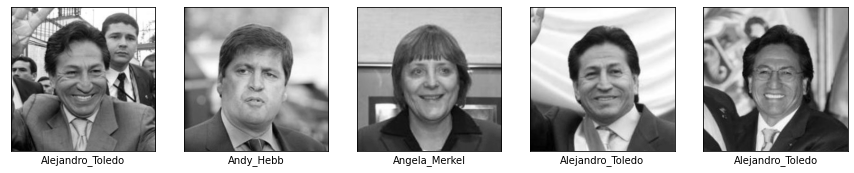

In [140]:
show_images(M, get_closest_proj(U, C, new_v, 5), names)

### c. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.